## Prerequisites

In [1]:
import torch
print(f'PyTorch version={torch.__version__}')

PyTorch version=2.3.1.post100


## Dataset

In [2]:
# Read file from github.com

from urllib.request import urlopen

target_url = 'https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt'
data = urlopen(target_url).read().decode('utf-8')

words = data.splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
print(f'Total words in dataset={len(words)}')

Total words in dataset=32033


In [5]:
min(len(w) for w in words)

2

In [6]:
max(len(w) for w in words)

15

## Bigram table background

In [7]:
# dictionary of key (tuple of ch -> ch) to value (count of occurrences)
b = {}

for w in words:
  # <S> is used to designate StartToken
  # <E> is used to designate EndToken
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [8]:
# Get sorted list of occurrences in descending order
freq = sorted(b.items(), key = lambda kv: -kv[1])
print('Top 10 frequent bigrams:')
freq[:10]

Top 10 frequent bigrams:


[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

## Bigram array matrix

In [9]:
# Rows are from char, Columns are to char
N = torch.zeros((27, 27), dtype=torch.int32)
N.shape

torch.Size([27, 27])

In [10]:
# Get unique characters for indexing. 26 since ascii only with special for start, end
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [11]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1
    

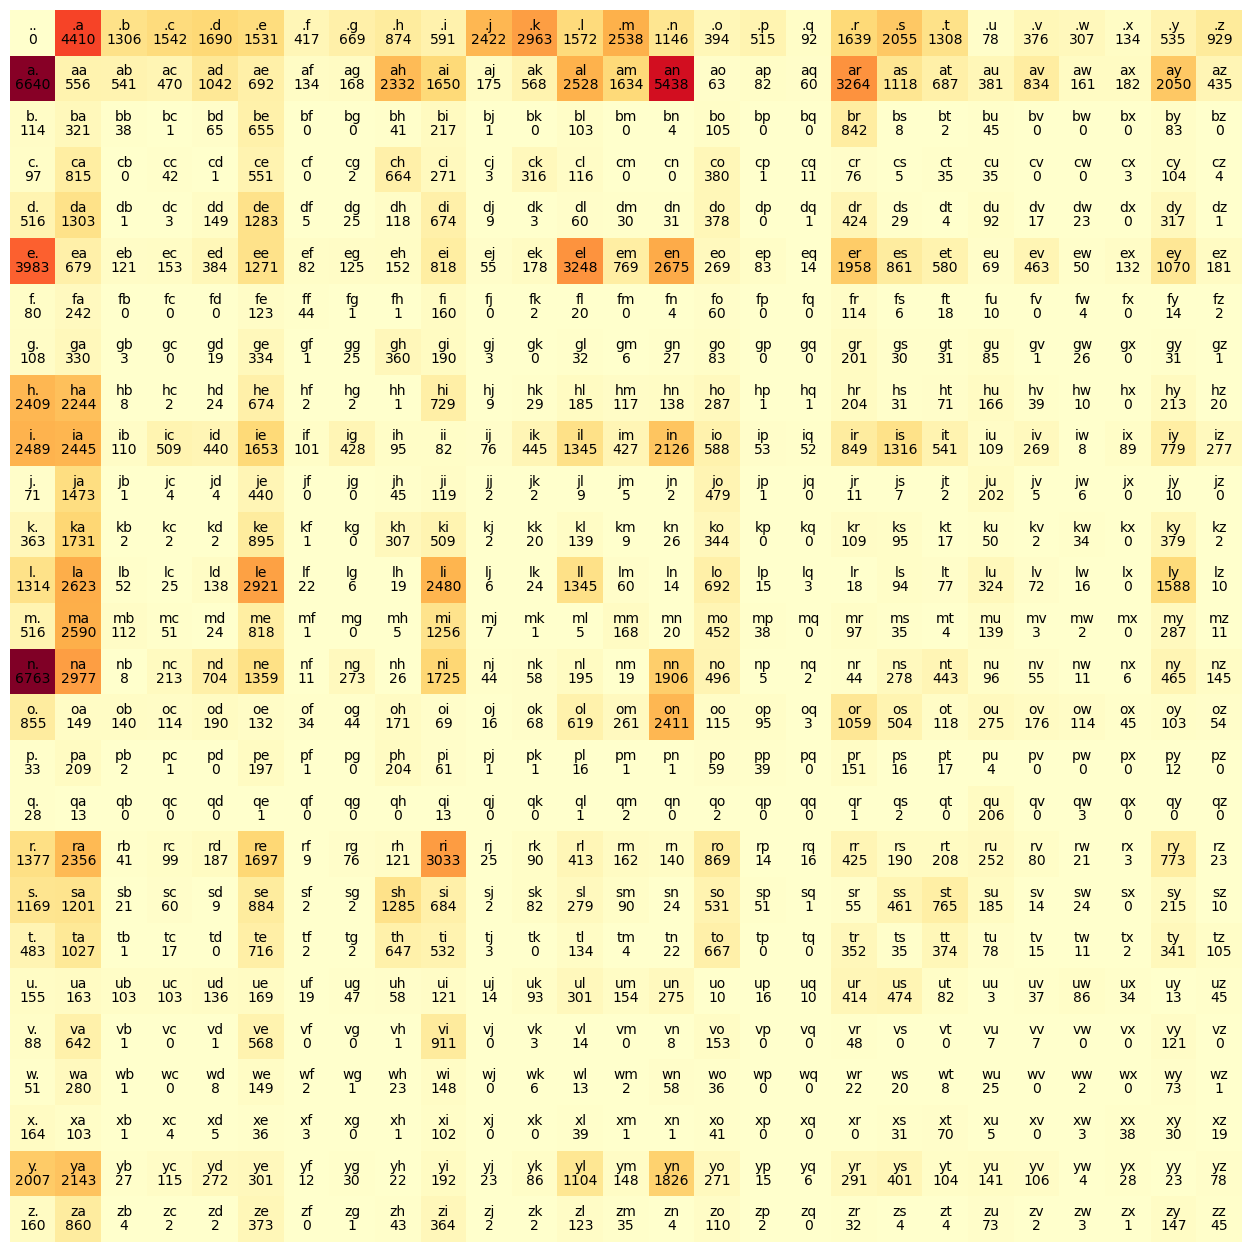

In [12]:
# Render frequency matrix
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='YlOrRd')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');
plt.show()

In [13]:
# First row of frequency matrix which is for choosing start and next character
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
# Normalize the first row to get probability distribution
p = N[0].float()
p = p / p.sum()
print(f'Probability distribution\n{p}\nSum={p.sum()}')

Probability distribution
tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
Sum=1.0


In [15]:

# Create a random generator with fixed seed
g = torch.Generator().manual_seed(2147483647)

# Sample from the distribution
ix = torch.multinomial(
    p, # Tensor of probabilities
    num_samples=1,
    replacement=True, # After fetching index, should it be reused? Not applicable for 1 sample
    generator=g
).item()
itos[ix]

'c'

In [16]:
# Create a random generator with fixed seed
g = torch.Generator().manual_seed(2147483647)

# Create 10 random names
for _ in range(10):
    # Start with . token
    ix = 0
    out = []
    while True:
        p = N[ix].float()
        p = p / p.sum()
        # Pick a random next char
        ix = torch.multinomial(
            p,
            num_samples=1,
            replacement=True,
            generator=g
        ).item()
        out.append(itos[ix])
        if ix == 0:
            # Found end token
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [17]:
# Optimize probability calculation
P = (N + 1).float() # Convert to float. Add 1 for model smoothing.
P /= P.sum(dim=1, keepdim=True) # Find sum of each row to get a 27,1 tensor. P 27,27 is then divided by sum which is possible because of broadcasting.

In [18]:
# Use optimized probability calculation
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
  ix = 0
  out = []
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


## Calculate loss

In [19]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [20]:
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'average_nll={nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
average_nll=2.4543561935424805


## Training model as Neural Network

In [21]:
# create the training set of bigrams (x,y)
xs, ys = [], []

# Use only first word for now
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [22]:
xs

tensor([ 0,  5, 13, 13,  1])

In [23]:
ys

tensor([ 5, 13, 13,  1,  0])

In [24]:
# One hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

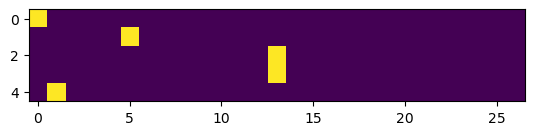

In [25]:
plt.imshow(xenc)
plt.show()

In [26]:
W = torch.randn((27, 1))
xenc @ W # 5,27 @ 27,1 = 5,1

tensor([[ 1.0166],
        [-0.7312],
        [ 0.7719],
        [ 0.7719],
        [-0.4479]])

In [27]:
logits = xenc @ W # Assume these are log-counts
counts = logits.exp() # Equivalent to the N matrix
probs = counts / counts.sum(1, keepdims=True) # Normalize to get probabilities
probs

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [28]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [29]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [30]:
probs.shape

torch.Size([5, 27])

In [31]:

nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

## Backward pass for Neural Network

In [32]:
xs

tensor([ 0,  5, 13, 13,  1])

In [33]:
ys

tensor([ 5, 13, 13,  1,  0])

In [34]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [35]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [36]:
print(loss.item())

3.7693049907684326


In [37]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [38]:
W.data += -0.1 * W.grad

In [39]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
new_loss = -probs[torch.arange(5), ys].log().mean()
print(new_loss.item())
print(f'Loss reduction = {loss.item() - new_loss.item()}')

3.7492129802703857
Loss reduction = 0.020092010498046875


## Complete Neural Network

In [40]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [41]:
# gradient descent
for k in range(101):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # Added smoothing aka regularization
  if k % 10 == 0:
    print(f'iteration={k} loss={loss.item()}')
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -5 * W.grad

iteration=0 loss=3.7686190605163574
iteration=10 loss=3.4086484909057617
iteration=20 loss=3.1900951862335205
iteration=30 loss=3.0504343509674072
iteration=40 loss=2.9537928104400635
iteration=50 loss=2.883265495300293
iteration=60 loss=2.8298776149749756
iteration=70 loss=2.788121223449707
iteration=80 loss=2.7544913291931152
iteration=90 loss=2.7267346382141113
iteration=100 loss=2.7033774852752686


## Sampling

In [42]:
# sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

dexzmalegllusailezktxha.
kllimittain.
lgdan.
ka.
da.
